# Evaluate planing quality

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from skimage import segmentation, measure

import os
import re
import glob

from skimage import io

In [2]:
root = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Planning_user_study'
#root = r'E:\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'
#root = r'C:\Users\schnei17\Documents\PhD\Paper\Protonenradiografie\planning_study\Planning_user_study'

In [3]:
anonymize = False
save_figures = True

In [4]:
animals = os.listdir(root)
animals

['P1_H_B6_M52',
 'P1_H_B6_M57',
 'P1_H_B6_M61',
 'P1_H_C3H_M46',
 'P1_H_C3H_M48',
 'P1_H_C3H_M54',
 'P1_H_C3H_M58',
 'P2E_M11',
 'P2E_M14',
 'P2E_M2']

Let's first get an overview of all conducted plans and the respective observer:

In [5]:
plans = {'animal': [], 'observer': [], 'filenames': []}
for animal in animals:
    filenames = glob.glob(os.path.join(root, animal, '*.tif'))
    plans['animal'] += [animal] * len(filenames)
    plans['observer'] += [os.path.basename(f).split('_')[0] for f in filenames]
    plans['filenames'] += [os.path.basename(f) for f in filenames]

plans = pd.DataFrame(plans)
plans
    

,animal,observer,filenames
0,P1_H_B6_M52,JM,JM_220510_P1_H_B6_M52_Plan.tif
1,P1_H_B6_M52,JM,JM_220513_P1_H_B6_M52_Plan.tif
2,P1_H_B6_M52,JM,JM_220519_P1_H_B6_M52_Plan.tif
3,P1_H_B6_M52,MS,MS_P1_H_B6_M52_replanning.tif
4,P1_H_B6_M52,TS,TS_P1_H_B6_M52_Plan_2022-0505.tif
5,P1_H_B6_M57,JM,JM_220510_P1_H_B6_M57_Plan.tif
6,P1_H_B6_M57,JM,JM_220519_P1_H_B6_M57_Plan.tif
7,P1_H_B6_M57,JM,JM_220523_P1_H_B6_M57_Plan.tif
8,P1_H_B6_M57,MS,MS_P1_H_B6_M57_replanning.tif
9,P1_H_B6_M57,TS,TS_P1_H_B6_M57_Plan_2022-0505.tif


In [79]:
def get_plans(plan_file: str) -> np.ndarray:
    """Retrieve plan from file"""
    plan = io.imread(plan_file).astype(np.uint16)

    plan_index = 0
    for z in range(plan.shape[0]):
        if len(np.unique(plan[z])) == 3:
            plan_index = z
    plan = segmentation.relabel_sequential(plan[plan_index])[0]

    return plan

def fuse_plans(plan_stack: np.ndarray) -> np.ndarray:
    """Fuse multiple plan files in a stack into a single image using a majority vote approach."""
    return np.asarray(stats.mode(plan_stack, axis=0))[0].squeeze()

def calculate_jaccard_score(plan_stack: np.ndarray, plan_fused: np.ndarray):
    """Calculate the jaccard score for a stack of plans and a reference fused plan"""
    
    JC = []
    for idx, plan in enumerate(plan_stack):
        JC.append(metrics.jaccard_score(plan_fused.flatten(), plan.flatten(), average=None))
    df = pd.DataFrame(JC, columns = [f'JC Label: {i}' for i in range(plan.max() + 1)])    
    return df

def make_pretty_plan_overlay(stack_of_plans: np.ndarray, fused_plans: np.ndarray):
    """Make a nice figure to show the hippocampal estimations of different observers compared to their consensus"""
        
    sns.set_style("white")
    props = measure.regionprops_table(fused_plans, properties=['slice'])

    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(fused_plans[props['slice'][0]], cmap='gray_r')

    for idx, plan in enumerate(stack_of_plans):
        sub = plan[props['slice'][0]]
        binary = sub == sub.max()
        contours = measure.find_contours(binary)
        ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2, label=f'Observer {idx}')
    
    ax.legend(fontsize=14)
    
#def calculate_centroid_distance(plan_stack: np.ndarray, plan_fused: np.ndarray):

## Inter-observer variability

We first analyze inter-observer variability. For this, we remove occurrences of repeated plannings of animals by single users. More precisely, if an observer repeated the planning of the same animal multiple times, we keep only the results of the first run.

In [7]:
inter_observer = plans.drop_duplicates(subset = ['observer', 'animal'], keep='first')

In [8]:
for animal in animals:
    _plans = inter_observer[inter_observer['animal'] == animal]
    plan_data = [get_plans(os.path.join(root, animal, f)) for f in _plans['filenames']]
    plan_data = np.stack(plan_data)
    
    plan_data_fused = fuse_plans(plan_data)
    jc = calculate_jaccard_score(plan_data, plan_data_fused)
    inter_observer.loc[inter_observer[inter_observer['animal'] == animal].index, jc.columns] = jc.to_numpy()
    #print(animal, jc.columns)

In [9]:
inter_observer

,animal,observer,filenames,JC Label: 0,JC Label: 1,JC Label: 2
0,P1_H_B6_M52,JM,JM_220510_P1_H_B6_M52_Plan.tif,0.997534,0.951002,0.974943
3,P1_H_B6_M52,MS,MS_P1_H_B6_M52_replanning.tif,0.997946,0.920086,0.739698
4,P1_H_B6_M52,TS,TS_P1_H_B6_M52_Plan_2022-0505.tif,0.997356,0.903630,0.702290
5,P1_H_B6_M57,JM,JM_220510_P1_H_B6_M57_Plan.tif,0.996169,0.909667,0.920617
8,P1_H_B6_M57,MS,MS_P1_H_B6_M57_replanning.tif,0.997602,0.903205,0.709005
9,P1_H_B6_M57,TS,TS_P1_H_B6_M57_Plan_2022-0505.tif,0.998379,0.947279,0.873975
10,P1_H_B6_M61,MS,MS_P1_H_B6_M61_replanning.tif,0.997012,0.889638,0.704180
11,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_2022-05-13.tif,0.998746,0.939108,0.776596
14,P1_H_C3H_M46,JM,JM_220513_P1_H_B6_M46_Plan.tif,0.998260,0.934858,0.908405
15,P1_H_C3H_M46,MS,MS_P1_H_C3H_M46_replanning.tif,0.999277,0.954598,0.851256


### Visualization and quantification

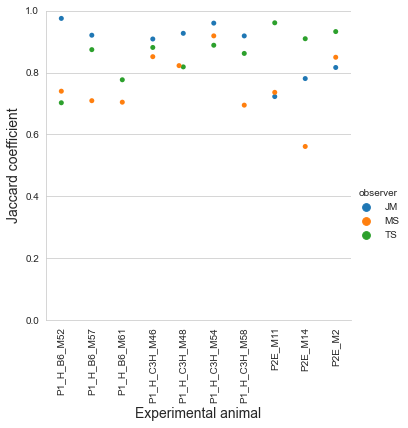

In [10]:
sns.set_style("whitegrid")
g = sns.catplot(data=inter_observer, x='animal', y='JC Label: 2', hue='observer', kind='swarm')
g.set_xticklabels(rotation=90)
g.set_xlabels('Experimental animal', fontsize=14)
g.set_ylabels('Jaccard coefficient', fontsize=14)
g.set(ylim=[0, 1])

In [65]:
mean = inter_observer['JC Label: 2'].mean()
std = inter_observer['JC Label: 2'].std()
print(f'Mean Jaccard index: {mean} +/- {std}')

Mean Jaccard index: 0.8316696586113963 +/- 0.10220152867693373


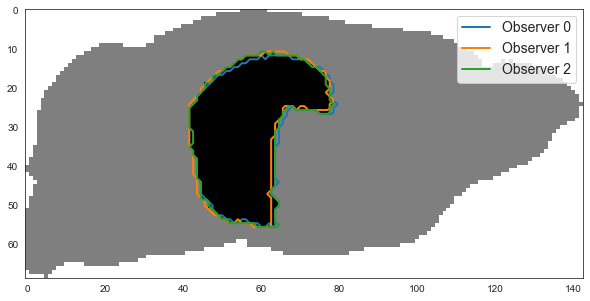

In [80]:
make_pretty_plan_overlay(plan_data, plan_data_fused)

## Intra-observer variability

We now analyze intra-observer variability.

In [13]:
intra_observer = plans[plans.duplicated(subset = ['observer', 'animal'], keep=False)]
intra_observer

,animal,observer,filenames
0,P1_H_B6_M52,JM,JM_220510_P1_H_B6_M52_Plan.tif
1,P1_H_B6_M52,JM,JM_220513_P1_H_B6_M52_Plan.tif
2,P1_H_B6_M52,JM,JM_220519_P1_H_B6_M52_Plan.tif
5,P1_H_B6_M57,JM,JM_220510_P1_H_B6_M57_Plan.tif
6,P1_H_B6_M57,JM,JM_220519_P1_H_B6_M57_Plan.tif
7,P1_H_B6_M57,JM,JM_220523_P1_H_B6_M57_Plan.tif
11,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_2022-05-13.tif
12,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_2022-0505.tif
13,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_TS_2022-05-16.tif
15,P1_H_C3H_M46,MS,MS_P1_H_C3H_M46_replanning.tif


In [14]:
for animal in animals:
    print(animal)
    _plans = intra_observer[intra_observer['animal'] == animal]
    plan_data = [get_plans(os.path.join(root, animal, f)) for f in _plans['filenames']]
    plan_data = np.stack(plan_data)
    
    plan_data_fused = fuse_plans(plan_data)
    jc = calculate_jaccard_score(plan_data, plan_data_fused)
    intra_observer.loc[intra_observer[intra_observer['animal'] == animal].index, jc.columns] = jc.to_numpy()


P1_H_B6_M52
P1_H_B6_M57
P1_H_B6_M61
P1_H_C3H_M46
P1_H_C3H_M48
P1_H_C3H_M54
P1_H_C3H_M58
P2E_M11
P2E_M14
P2E_M2


### Visualization and quantification

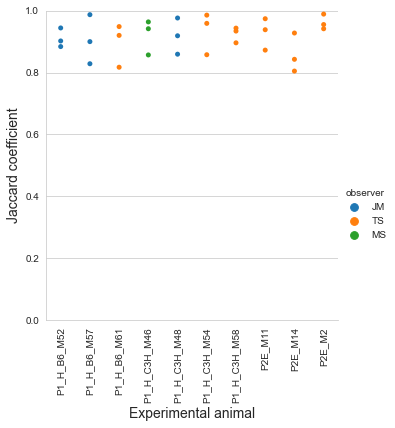

In [16]:
sns.set_style("whitegrid")
g = sns.catplot(data=intra_observer, x='animal', y='JC Label: 2', hue='observer', kind='swarm')
g.set_xticklabels(rotation=90)
g.set_xlabels('Experimental animal', fontsize=14)
g.set_ylabels('Jaccard coefficient', fontsize=14)
g.set(ylim=[0, 1])

In [17]:
mean = intra_observer['JC Label: 2'].mean()
std = intra_observer['JC Label: 2'].std()
print(f'Mean Jaccard index: {mean} +/- {std}')

Mean Jaccard index: 0.9156076666989403 +/- 0.05310499070147739


Text(0.5, 1.0, 'Fusion')

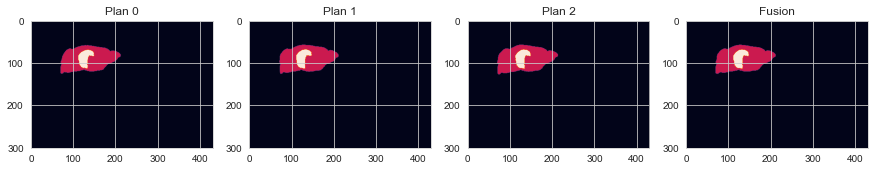

In [18]:
fig, ax = plt.subplots(ncols = len(plan_data)+1, figsize = (15, 10))
[ax[i].imshow(plan) for i, plan in enumerate(plan_data)]
[ax[i].set_title(f'Plan {i}') for i in range(len(plan_data))]
ax[-1].imshow(plan_data_fused)
ax[-1].set_title('Fusion')